# BTEX Neutron Cross-section Calculation Using AFGA

This notebook estimates the **hydrogen neutron cross-section** (H_CS) and the **total neutron cross section** (T_CS) of organic molecules — specifically BTEX compounds (Benzene, Toluene, Ethylbenzene, Xylenes) — using the **Average Functional Group Approximation (AFGA)** model from Romanelli et al. (2021) -https://doi.org/10.1088/1361-648X/abfc13.


The cross sections are computed as a function of neutron energy (eV) and wavelength (Å).

## 1. Theoretical Background

### 1.1 Neutron Energy–Wavelength Relation

This relation is used to convert between energy and wavelength. 
$$
E[\text{meV}] = \frac{81.804}{\lambda^2[\text{Å}]}
$$
Where:
- $ E $ : neutron energy in milielectronvolts (meV)
- $ \lambda $ : neutron wavelength in Ångströms

*Note: It is implemented as a function in the code.*

### 1.2 Hydrogen Cross Section Approximation (AFGA)

The hydrogen scattering cross section is modeled using a **4-parameter sigmoid function** (Romanelli et al.):

$$
\sigma_H(E) = s_f + \frac{s_b}{1 + c E^d}
$$

Where:
- $ s_f, s_b, c, d $ : empirically fitted parameters for each functional group
- $ E $: neutron energy in meV
- Units of $\sigma_H(E)$ : cross section in **barns**

*Note: They made an empirical model following the behavior of 20+ amino acids cross-sections.*

### 1.3 Total Molecular Cross Section

The total cross-section is approximated as:

$$
\sigma_\text{total}(E) = \sigma_H(E) + \sum_i N_i \cdot \sigma_{f,i}
$$

Where:
- $ \sigma_H(E) $ : total H contribution from all functional groups
- $ \sigma_{f,i} $ : free scattering cross section of non-H atoms (e.g., C, O, N)
- $ N_i $ : number of atoms of type \( i \)

*Note: In this Notebook, the cross sections per atom used are: C: 5.55, N: 11.53, O: 4.23, from Sears 1992, and are **not** energy-dependent as they should be. This is to keep things simple. *


## 2. Considerations & Limitations

One of the *most important* considerations is that the model takes the contribution of the **whole** functional group, so at the end, the hydrogen cross-sections (H-CS) require dividing the total number of H atoms in the molecule.

The following considerations limit the model's precision as seen in SNI experimental results:

- This model **neglects the correlation between functional groups**.
- Only H-CS are energy-dependent; **non-H atoms contribute constant free scattering values**.
- The model is optimized for **room temperature** (300 K).
- It is most accurate for **hydrogen-rich**, **soft organic** materials.

For BTEX components: AFGA only takes the **sum of average contributions from independent functional groups**, without accounting for coupling or spatial arrangement. This approach falls short in the following ways:

- Vibrational modes vary across different ring substitution patterns.
- Diffusion dynamics are not considered.
- **Molecules with the same number of functional groups**, and therefore H, **are not recognizable** (e.g., *m-*, *o-*, *p-* xylenes).
- **Intermolecular interactions missing**

### 2.1 Parameters and Constants

The energy range refers to values in **eV**, as defined in the Supplementary section of Romanelli et al. (2021)*. From 0.001 eV up to 10 eV. This can be modified in the code of `AFGA_app`.

Similarly, the *sigmoid parameters* correspond to the fitted curve values for the **hydrogen contributions to the CS, *averaged across all amino acids*** using the sigmoidal function (as described in Romanelli et al.) *Table 2*

| Functional Group    | sf (barns)     | sb (barns)     | c            | d            |
|-------------------- |----------------|----------------|--------------|--------------|
| **CH (aliphatic)**  | 19.14 ± 0.6    | 73.11 ± 1      | 37.46 ± 6    | 1.03 ± 0.04  |
| **CH (aromatic)**   | 17.51 ± 0.7    | 86.72 ± 2      | 28.62 ± 4    | 0.84 ± 0.04  |
| **CH₂**             | 16.20 ± 0.9    | 105.1 ± 3      | 23.40 ± 2    | 0.71 ± 0.03  |
| **CH₃**             | 13.60 ± 0.6    | 174.8 ± 7      | 27.14 ± 1    | 0.55 ± 0.02  |
| **NH₃**             | 18.82 ± 0.5    | 74.92 ± 1      | 32.90 ± 3    | 0.94 ± 0.03  |
| **NH₂**             | 17.54 ± 0.5    | 101.5 ± 2      | 28.75 ± 2    | 0.75 ± 0.02  |
| **NH**              | 19.10 ± 0.6    | 78.09 ± 1      | 36.39 ± 4    | 0.95 ± 0.03  |
| **OH**              | 19.27 ± 0.6    | 71.29 ± 1      | 44.57 ± 7    | 1.09 ± 0.05  |
| **SH**              | 19.24 ± 0.4    | 107.3 ± 2      | 60.64 ± 5    | 0.85 ± 0.02  |


## 3. AFGA Implementation and Example

In the following sections, we will implement two examples described in the article.  

From this point on, one of the **most important steps** is to **define or build the molecular compound** correctly.

### 3.1 Triphenylmethane ($(C_6H_5)_3CH$) and Poly(methyl methacrylate) ($CH_2C(CH_3)CO_2CH_3$) as examples.

This is an example of the AFGA approximation. 

<figure style="text-align:center">
    <img src=attachment:46b906e0-ed60-4a5a-9b0b-cd320da8c164.png width="200" style="margin-right: 100px">
    <img src=attachment:4426ad7a-70f7-4289-a833-5874ecd629cb.png width="200">
    <figcaption> Figure 1: (left) Ball-and-stick model of the triphenylmethane molecule and (right) composition of Poly(methyl methacrylate)</figcaption>
</figure>

Triphenylmethane contains **three aromatic groups** and **one aliphatic group**.  
In the AFGA approximation, this translates to **15 hydrogen atoms** bound to three cyclic aromatic groups ($CH_{aro}$), and **one hydrogen atom** bound to an aliphatic group ($CH_{ali}$).

Poly(methyl methacrylate) is treated as an independent repeating chain.  
According to the AFGA model: it contributes **6 hydrogens from $CH_3$ groups** and **2 hydrogens from $CH_2$ groups**.

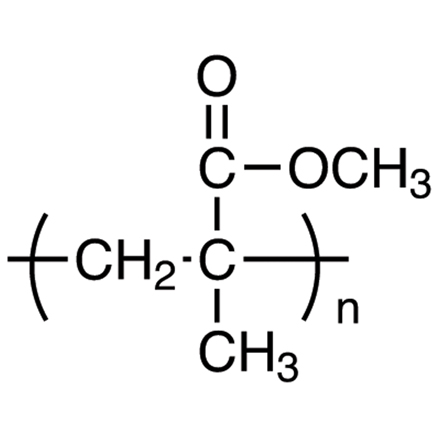
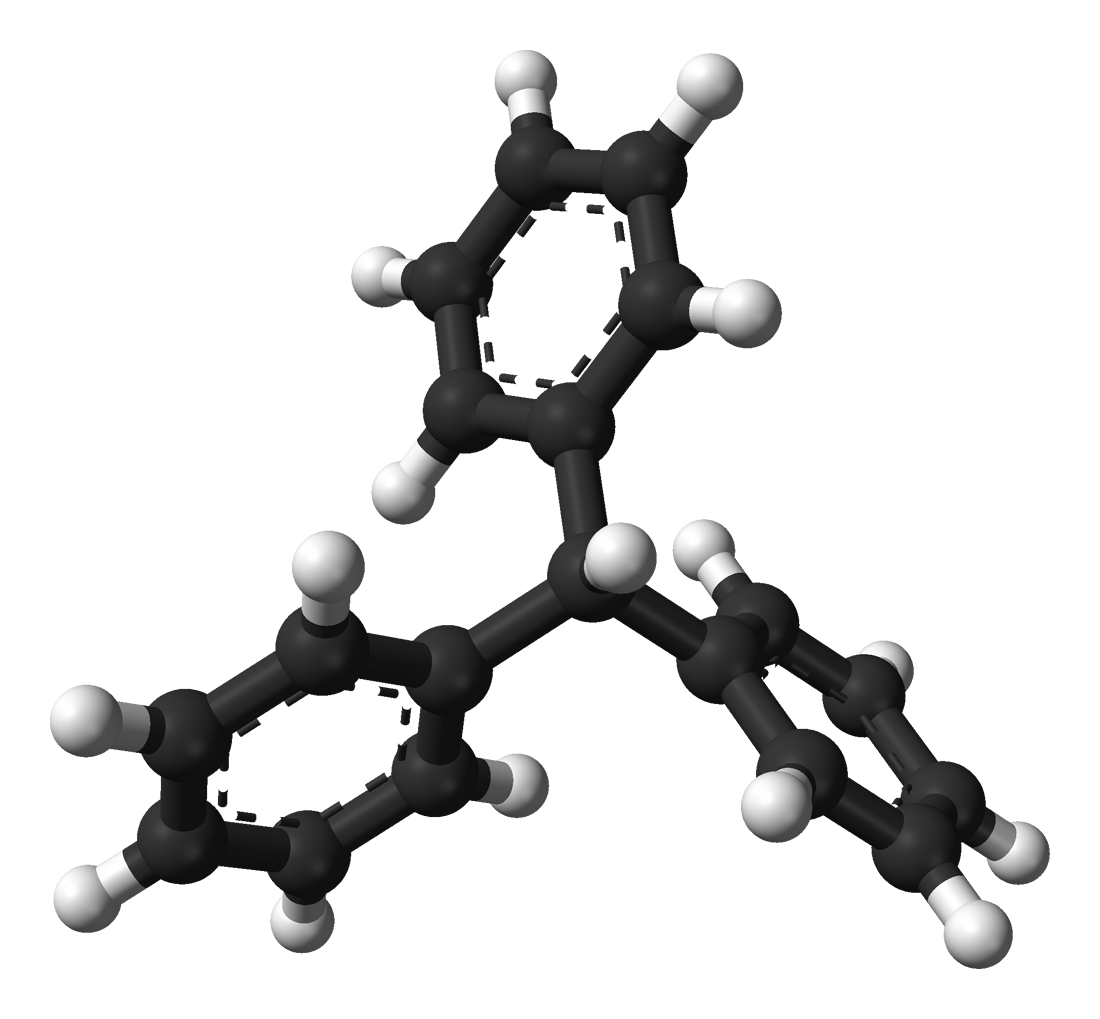

### 3.2 Importing Python functions

In [1]:
from AFGA_app import *

#### 3.2.1 Triphenylmethane

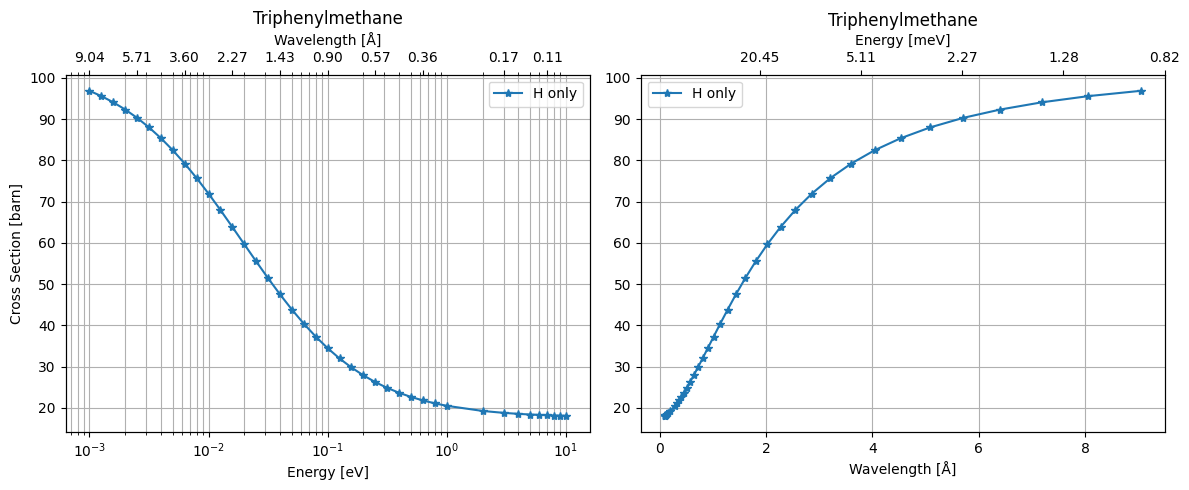

In [2]:
# Compound definitions
TPM = {
    "Triphenylmethane": ({"CH_aro": 15, "CH_ali": 1}, {"C": 19})}

# Total number of H atoms
H_tot = 16

# Function to extract the elements in the dictionary created
compound_name, (group_counts, non_H_atoms) = list(TPM.items())[0]

# Calculating the cross-sections
sigma_H, sigma_T = calc_CS(E_eV, group_counts, non_H_atoms)

# In case of not wanting the T CS in the plot, set sigma_T = 0.
sigma_T = 0

# Plotting
plot_dual_axes(compound_name, group_counts, non_H_atoms, E_eV, sigma_H, sigma_T, H_mod = H_tot)

#### 3.2.2 Poly(methyl methacrylate)

The same is done as in the previous cell.
In this case, only for representation, we leave the total CS snd plot it together.

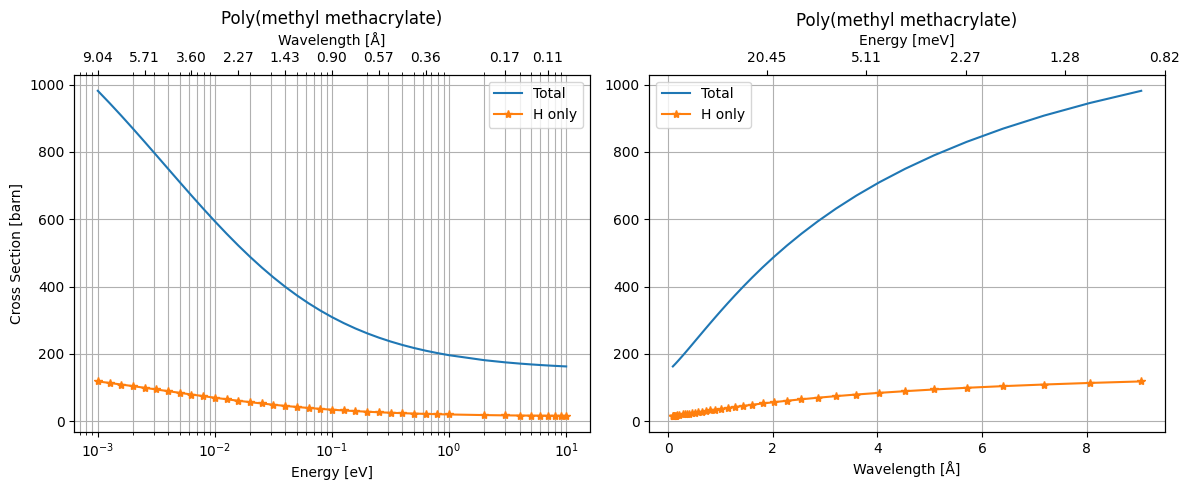

In [3]:
PMMA = {
    "Poly(methyl methacrylate)": ({"CH2": 2, "CH3": 6}, {"C": 5, "O": 2})}

H_tot = 8

compound_name, (group_counts, non_H_atoms) = list(PMMA.items())[0]

sigma_H, sigma_T = calc_CS(E_eV, group_counts, non_H_atoms)
#sigma_T = 0
plot_dual_axes(compound_name, group_counts, non_H_atoms, E_eV, sigma_H, sigma_T, H_mod = H_tot)

## 4. BTEX Compounds Overview

**BTEX+** includes: Benzene, Toluene, Ethylbenzene, Xylenes, Methanol, Ethanol, Methane, and Methylcyclohexane.

Each compound is built based on its functional groups.  
**Important:** The numbers in the table represent the total number of hydrogen atoms associated with each specific functional group.


| Compound              | Formula    | $CH_3$ | $CH_2$ | $CH_{aro}$ | $CH_{ali}$ | $OH$ | C atoms | O atoms |
| --------------------- | -          | -      | -      | -          | -          | -    | -       | -       |
| **Benzene**           | $C_6H_6$   | 0      | 0      | 6          | 0          | 0    | 6       | 0       |
| **Toluene**           | $C_7H_8$   | 3      | 0      | 5          | 0          | 0    | 7       | 0       |
| **Ethylbenzene**      | $C_8H_{10}$| 3      | 2      | 5          | 0          | 0    | 8       | 0       |
| **Xylenes**           | $C_8H_{10}$| 6      | 0      | 4          | 0          | 0    | 8       | 0       |
| **Methanol**          | $CH_4O$    | 3      | 0      | 0          | 0          | 1    | 1       | 1       |
| **Ethanol**           | $C_2H_6O$  | 3      | 2      | 0          | 0          | 1    | 2       | 1       | 
| **Methylcyclohexane** | $C_7H_{14}$| 3      | 10     | 0          | 1          | 0    | 7       | 0       |


> **Note:** Methane is not included in this model, as $CH_4$ is not part of the sigmoid parameterization in Romanelli et al.

### 4.1 Usage for BTEX+ Compounds

Create the full dictionary using tuples, where each entry counts the influence of hydrogen atoms bound to specific functional groups.  
For example, **Toluene** has 5 hydrogen atoms in $CH_{aro}$ groups and 3 in $CH_3$ groups. So that:

> `"Toluene": ({"CH3": 3, "CH_aro": 5}, {"C": 7}),`
*The second element of each tuple should include the count of non-hydrogen atoms (C, O, etc.).*

> **Note:** Only one isomer of xylene is included, as the functional group model does not differentiate between *m-*, *o-*, or *p-* isomers.


In [4]:
BTEX_p = {
    "Benzene":      ({"CH_aro": 6}, {"C": 6}),
    "Toluene":      ({"CH3": 3, "CH_aro": 5}, {"C": 7}),
    "Ethylbenzene": ({"CH3": 3, "CH2": 2, "CH_aro": 5}, {"C": 8}),
    "Xylene":       ({"CH3": 6, "CH_aro": 4}, {"C": 8}),
    "Methanol":     ({"CH3": 3, "OH": 1}, {"C": 1, "O": 1}),
    "Ethanol":      ({"CH3": 3, "CH2": 2, "OH": 1}, {"C": 2, "O": 1}),
    "Methylcyclohexane": ({"CH3": 3, "CH2": 10, "CH_ali": 1}, {"C": 7})}

The `get_compound_info` function extracts information for a selected compound.  
It generalizes the earlier implementations to reduce the amount of code repetition and keep the notebook cells cleaner.

In [5]:
def get_compound_info(name, full_dict):
    compound = {name: full_dict[name]}
    group_counts = list(compound.values())[0][0]
    return compound, sum(group_counts.values())

Usage of `get_compound_info` alongside the functions presented before in sections 3.2.1 and 3.2.2.

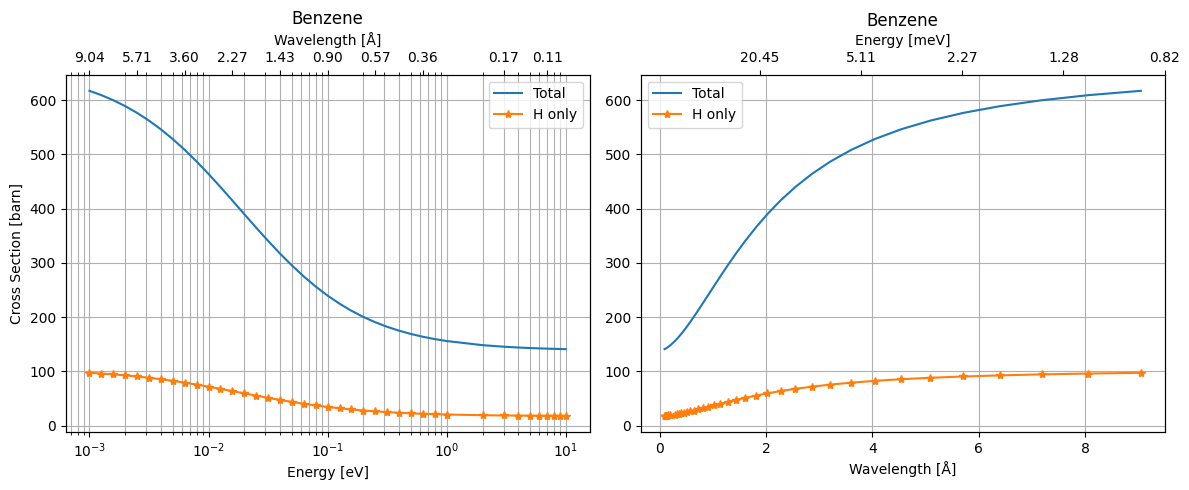

In [6]:
curr_dict, H_tot = get_compound_info("Benzene", BTEX_p)

compound_name, (group_counts, non_H_atoms) = list(curr_dict.items())[0]
sigma_H, sigma_T = calc_CS(E_eV, group_counts, non_H_atoms)
#sigma_T = 0
plot_dual_axes(compound_name, group_counts, non_H_atoms, E_eV, sigma_H, sigma_T, H_mod = H_tot)

**New definition of `get_compound_CS`**: This function is a generalized version of the earlier cross-section calculators and is designed to work with the updated `get_compound_info`.

With a single line of code, `get_compound_CS` allows you to generate both **hydrogen only** and **total cross-section** plots for a given compound.

The `total_CS` argument controls if the total cross-section should be included in the plot:
  - Set `total_CS=True` to calculate **total cross-sections** (hydrogen + non-hydrogen contributions).
  - Set `total_CS=False` to compute **hydrogen-only cross-sections**.

This replaces the previous manual approach of comment/uncomment `sigma_T = 0`.


In [7]:
def get_compound_CS(name, full_dict, total_CS=True):
    
    curr_dict, H_tot = get_compound_info(name, full_dict)
    compound_name, (group_counts, non_H_atoms) = list(curr_dict.items())[0]
    
    sigma_H, sigma_T = calc_CS(E_eV, group_counts, non_H_atoms)
    
    if not total_CS:
        sigma_T = 0
    plot_dual_axes(compound_name, group_counts, non_H_atoms, E_eV, sigma_H, sigma_T, H_mod = H_tot)
    
    print(f"Total H count in {name} is: {H_tot}")

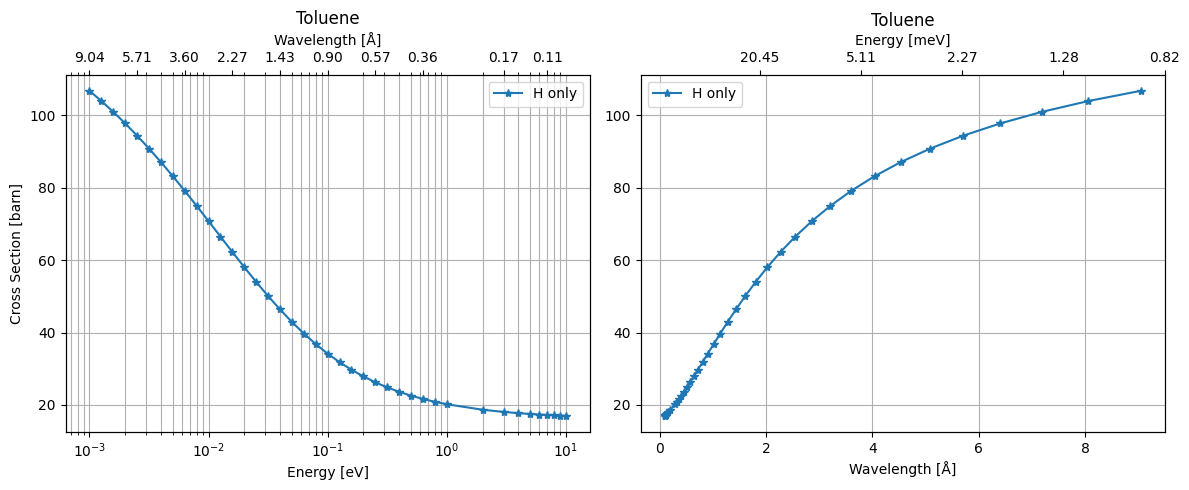

Total H count in Toluene is: 8


In [8]:
get_compound_CS('Toluene', BTEX_p, total_CS=False)

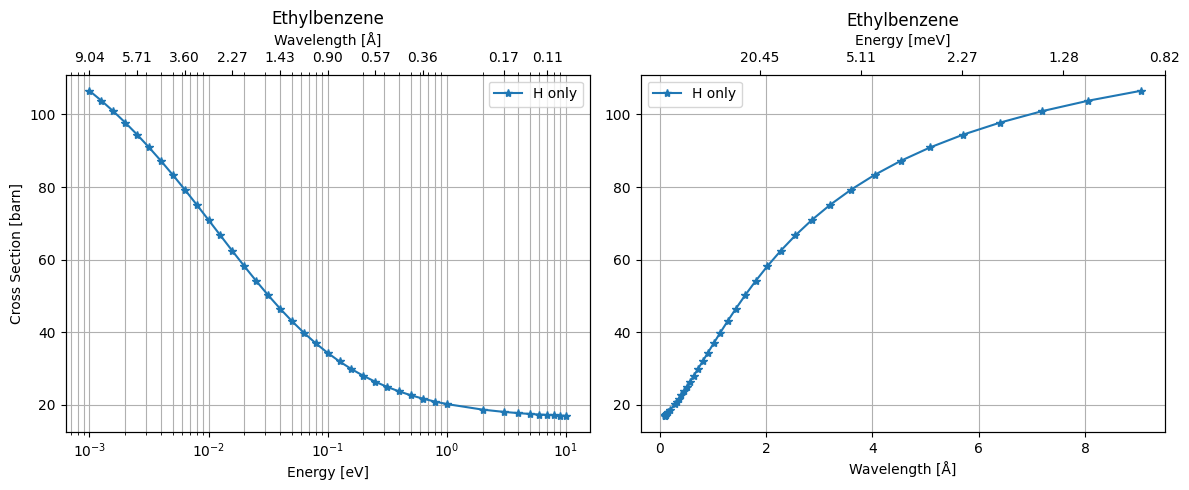

Total H count in Ethylbenzene is: 10


In [9]:
get_compound_CS('Ethylbenzene', BTEX_p, total_CS=False)

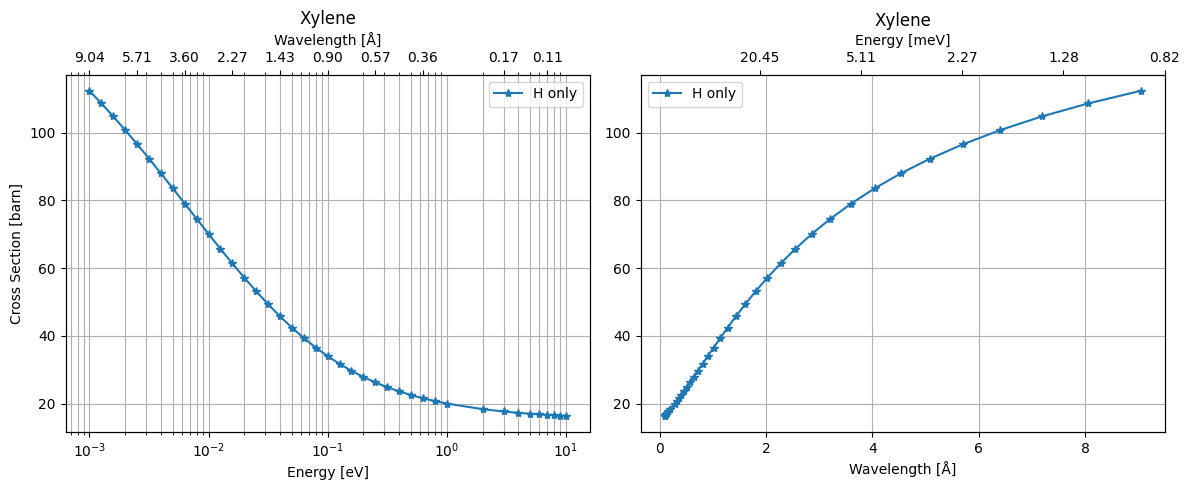

Total H count in Xylene is: 10


In [10]:
get_compound_CS('Xylene', BTEX_p, total_CS=False)

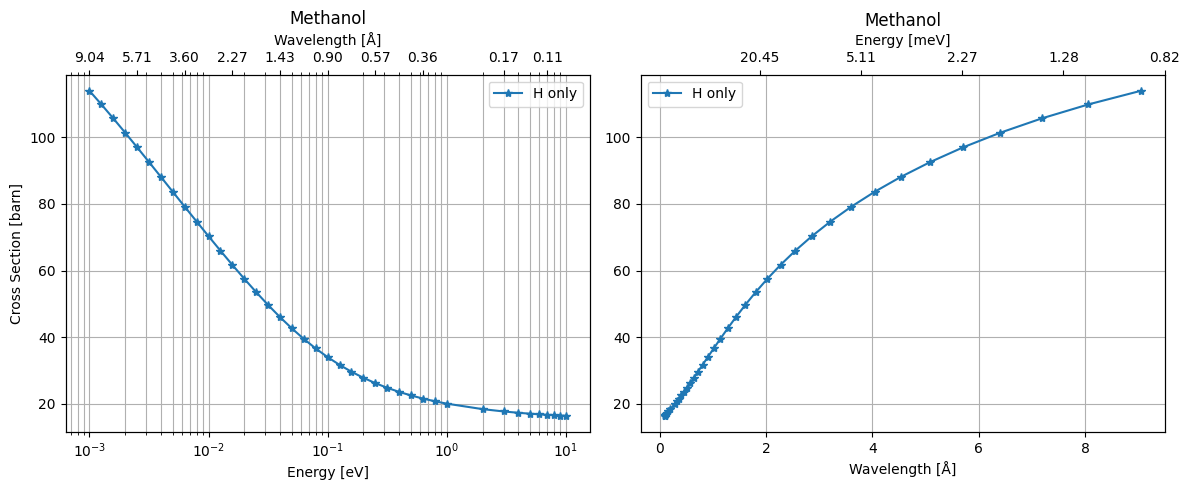

Total H count in Methanol is: 4


In [11]:
get_compound_CS('Methanol', BTEX_p, total_CS=False)

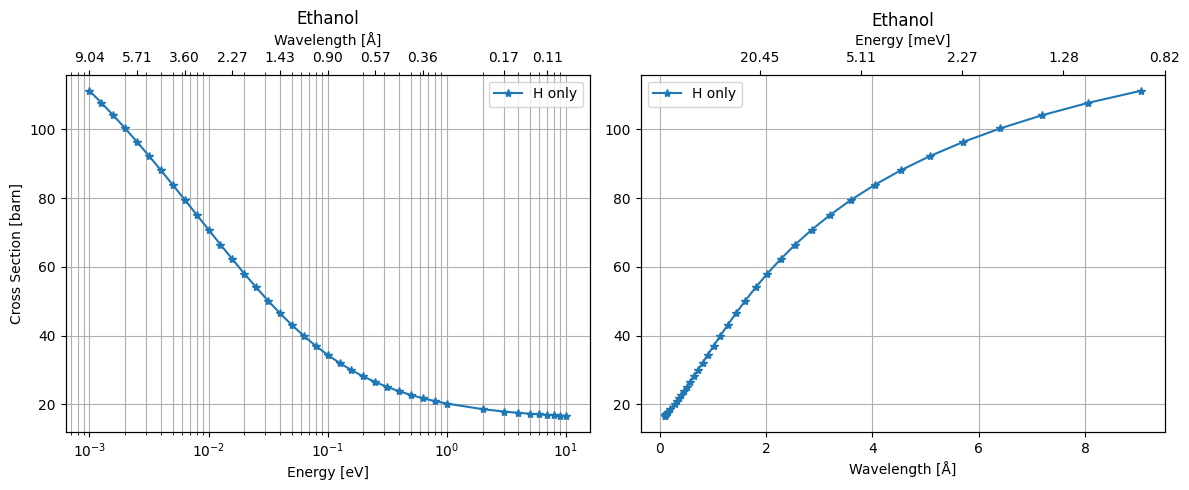

Total H count in Ethanol is: 6


In [12]:
get_compound_CS('Ethanol', BTEX_p, total_CS=False)

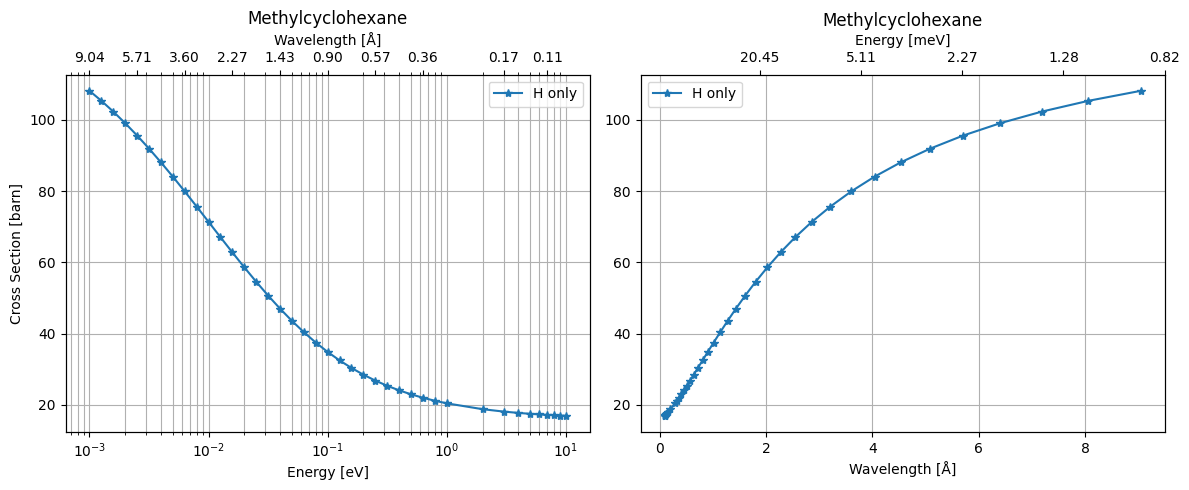

Total H count in Methylcyclohexane is: 14


In [13]:
get_compound_CS('Methylcyclohexane', BTEX_p, total_CS=False)

### 4.2 Plotting All BTEX+ Compounds Together

The function `plot_all_CS` is used to visualize all compounds defined in a dictionary—in this case, the full BTEX+ set.

Plots are arranged in a **2×1 grid** (instead of the earlier 1×2) for improved readability and layout.

#### Optional Zoom Controls

You can define custom axis limits to zoom in on specific regions of the plots:

- `energy_limits = [(min_energy_eV, max_energy_eV), (min_CS_barns, max_CS_barns)]`  
  → Limits the **Energy vs. Cross-Section** plot.

- `wvl_limits = [(min_wavelength_Å, max_wavelength_Å), (min_CS_barns, max_CS_barns)]`  
  → Limits the **Wavelength vs. Cross-Section** plot.

These parameters are optional and can be omitted if full-range plots are preferred.

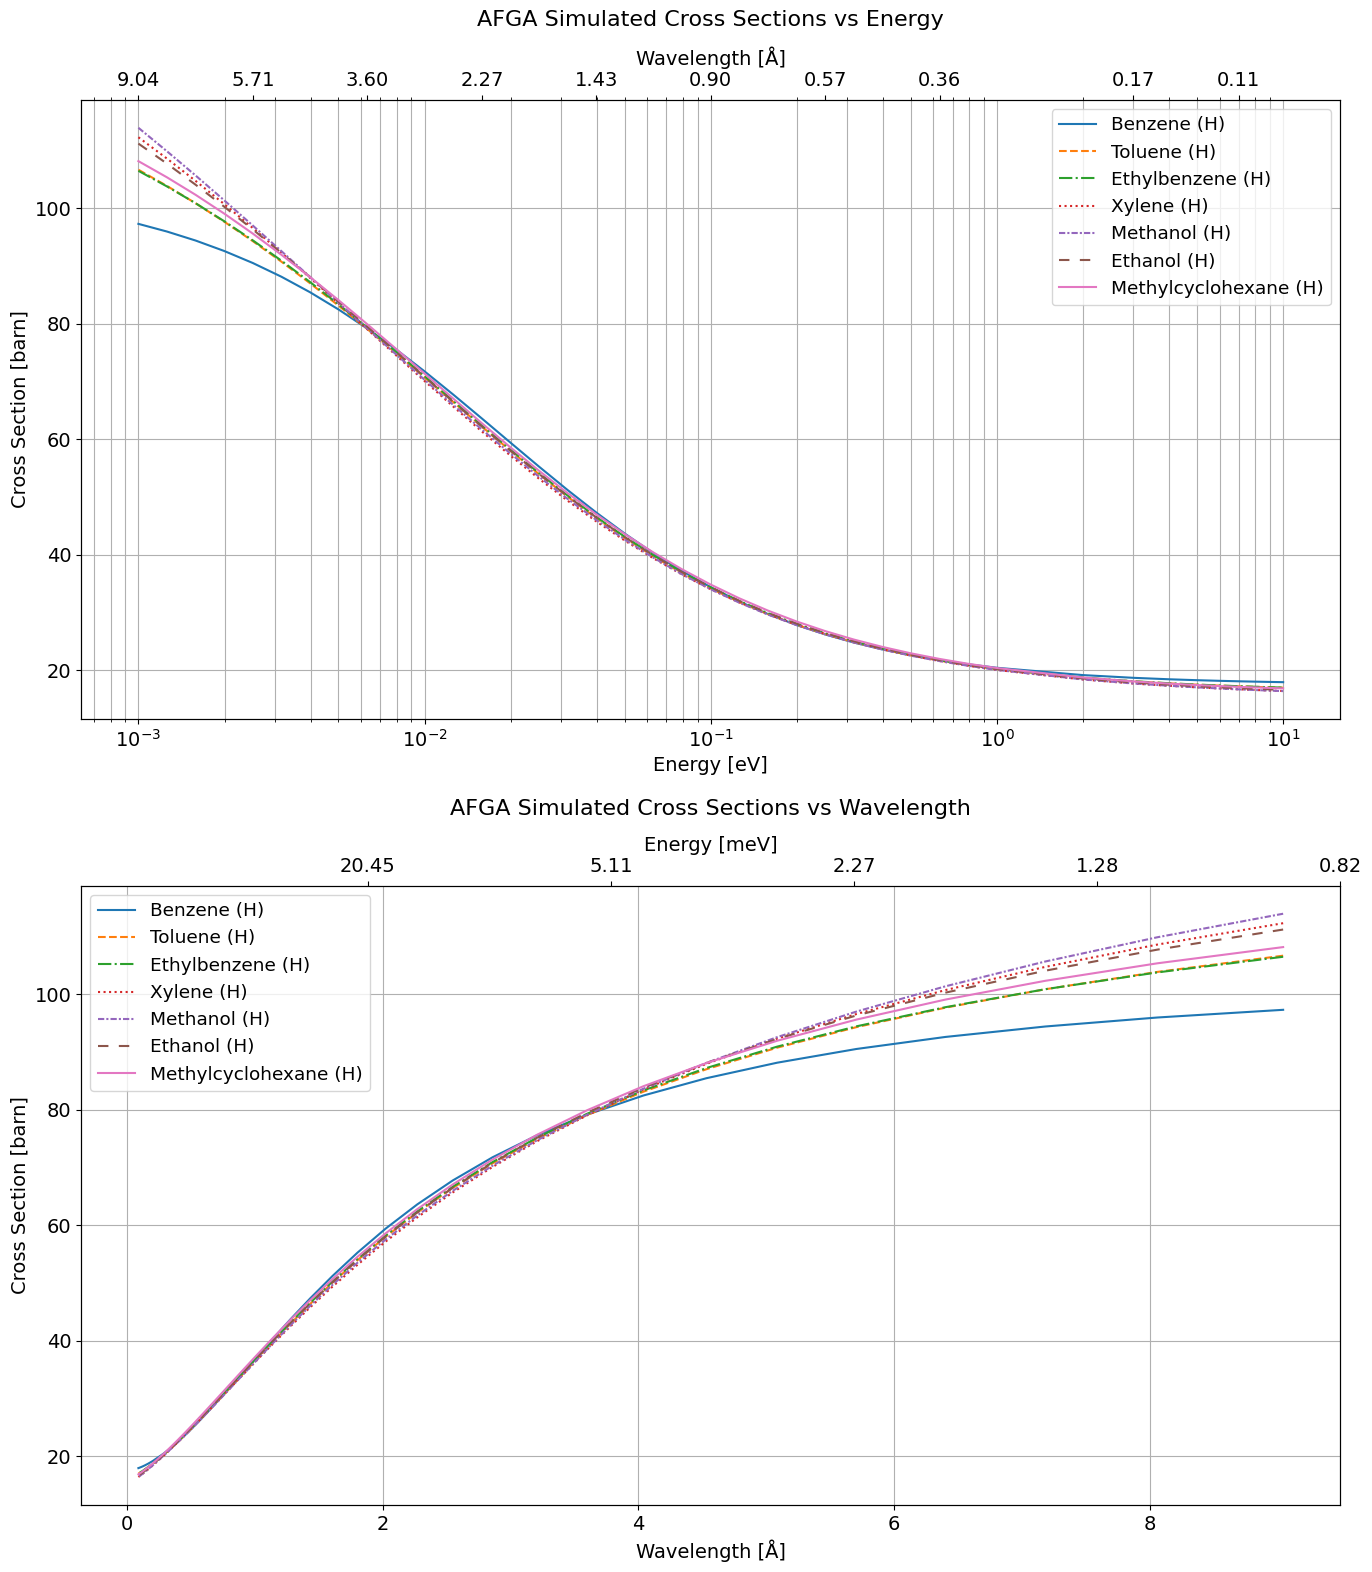

In [14]:
plot_all_CS(BTEX_p, E_eV, calc_CS, plot_H=True, plot_T=False)

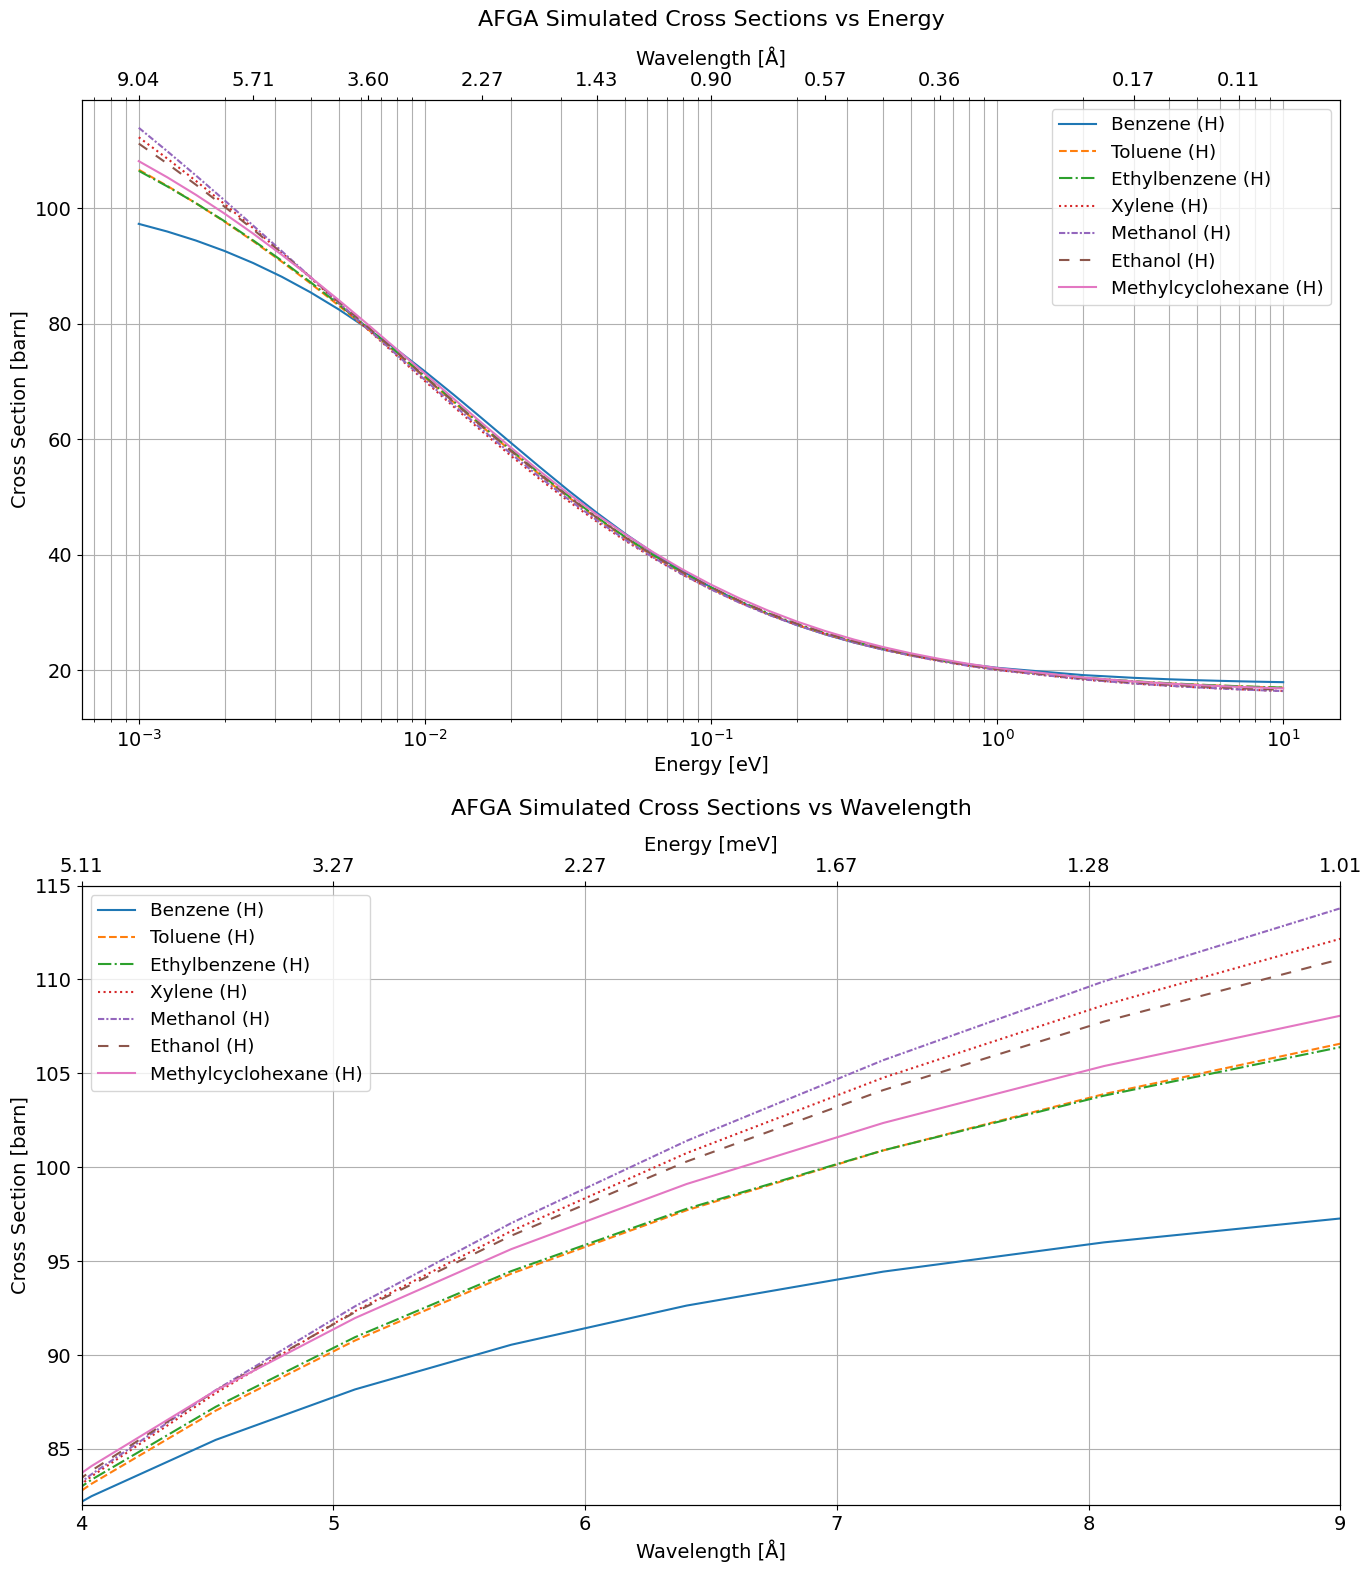

In [15]:
plot_all_CS(BTEX_p, E_eV, calc_CS, plot_T=False, #energy_limits=[(0.001, 0.01), (60, 120)], 
            wvl_limits=[(4, 9), (82, 115)])

## 5. Example for Tabulated Organic Solvents in Battery Electrolytes

Now we can compare the AFGA approximation to compounds measured experimentally, e.g., battery solvents

In [16]:
Bat_sol = {
    "PE":  ({"CH2": 4}, {"C": 2}),
    "EC":  ({"CH2": 4}, {"C": 3, "O": 3}),
    "DMC": ({"CH3": 6}, {"C": 3, "O": 3}),
    "DEC": ({"CH3": 6, "CH2": 4}, {"C": 5, "O": 3}),}

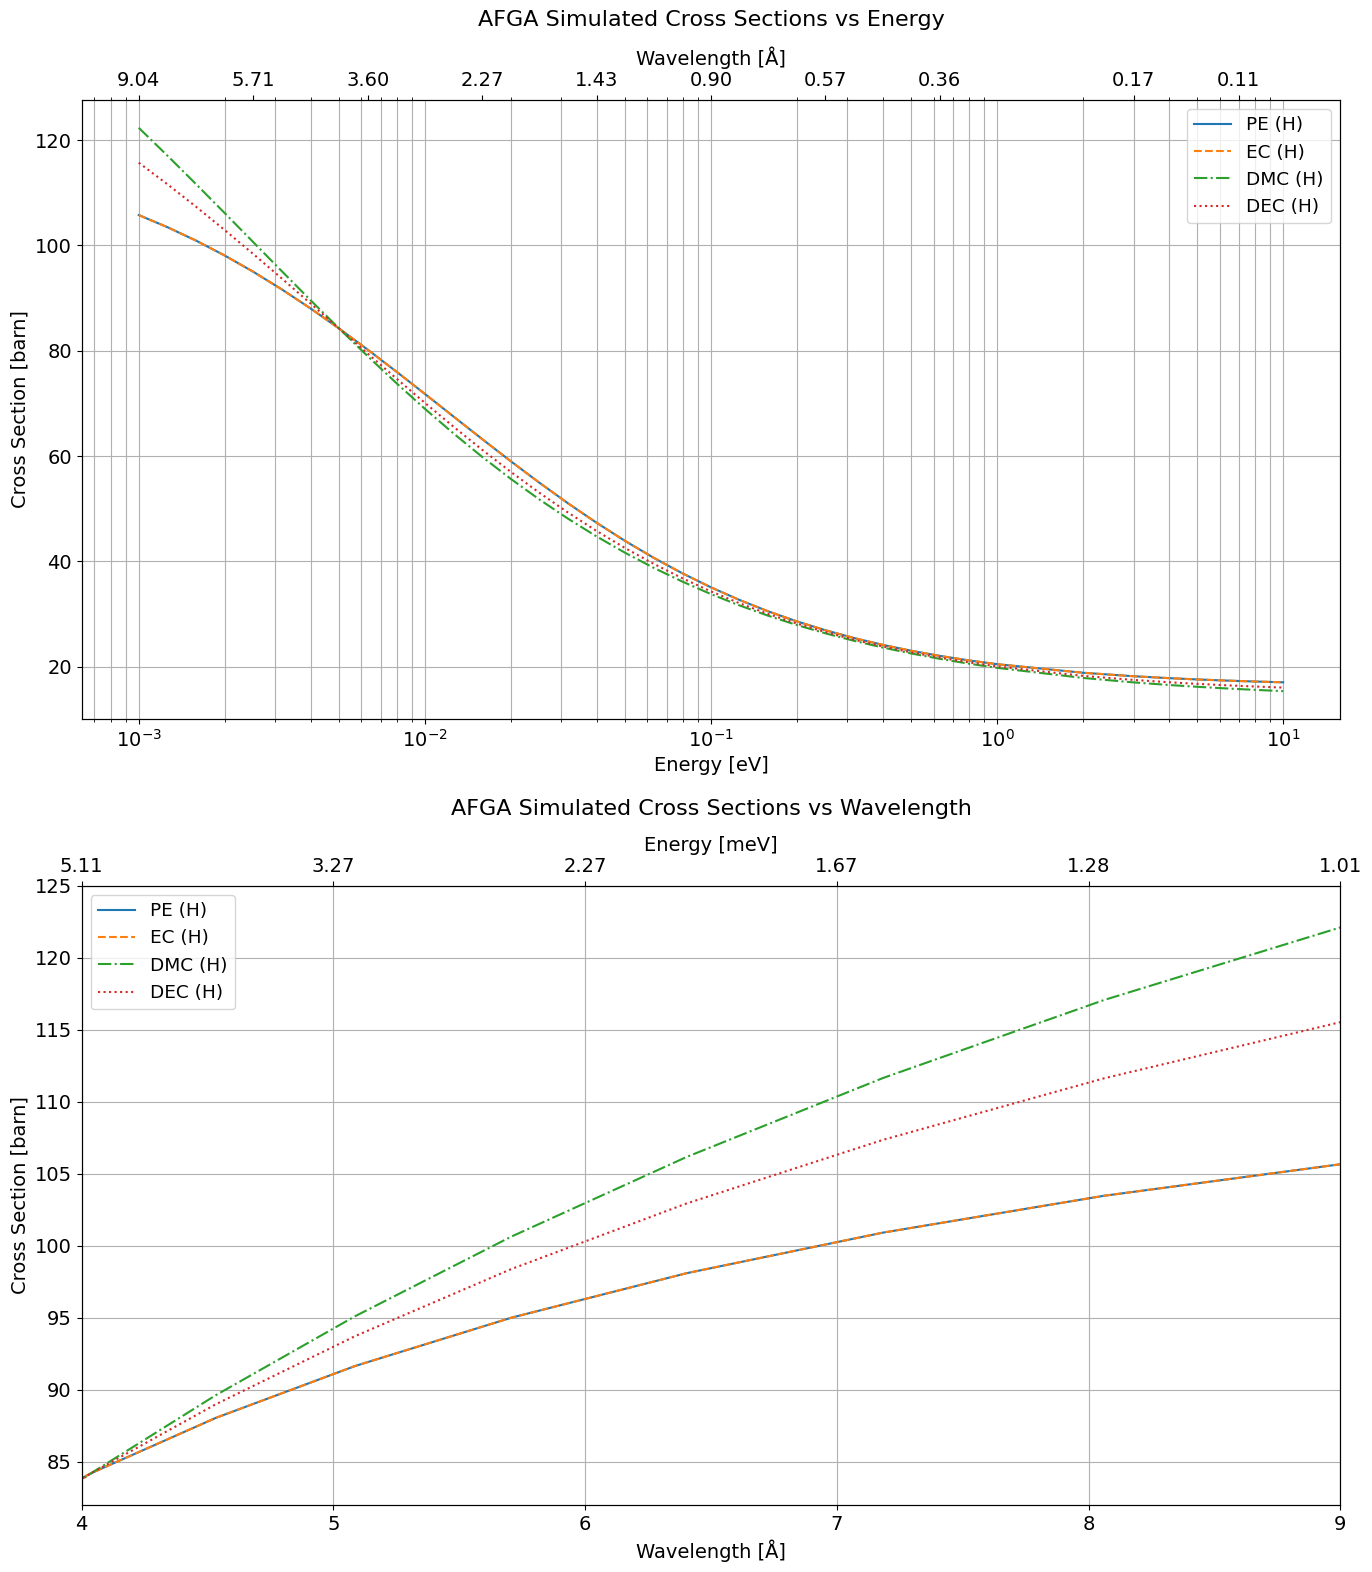

In [17]:
plot_all_CS(Bat_sol, E_eV, calc_CS, plot_H=True, plot_T=False, wvl_limits=[(4, 9), (82, 125)])

**As observed, the AFGA approximation fails to account for dynamic interactions in liquids—particularly when it comes to distinguishing the same amount of hydrogen from functional groups and (in this case) the cyclic carbonate ester of ethylene glycol and carbonic acid** 

That is, it does not differentiate between the hydrogen in $CH_2$ groups in a polyethylene (PE) chain and those within the cyclic carbonate ester of ethylene carbonate (EC).

**On a good note**, the H-CS predicted for **dimethyl carbonate (DMC) and ethylene carbonate (DEC)** are **very close** to the experimental values reported by Carreón Ruiz et al. (2023) in *"Spectroscopic neutron imaging for resolving hydrogen dynamics changes in battery electrolytes."*


## 6. Testing new examples *from Pavel*

In [18]:
test = {
    "T1":  ({"CH2": 4}, {"C": 2}),
    "T2":  ({"CH3": 6}, {"C": 2})}

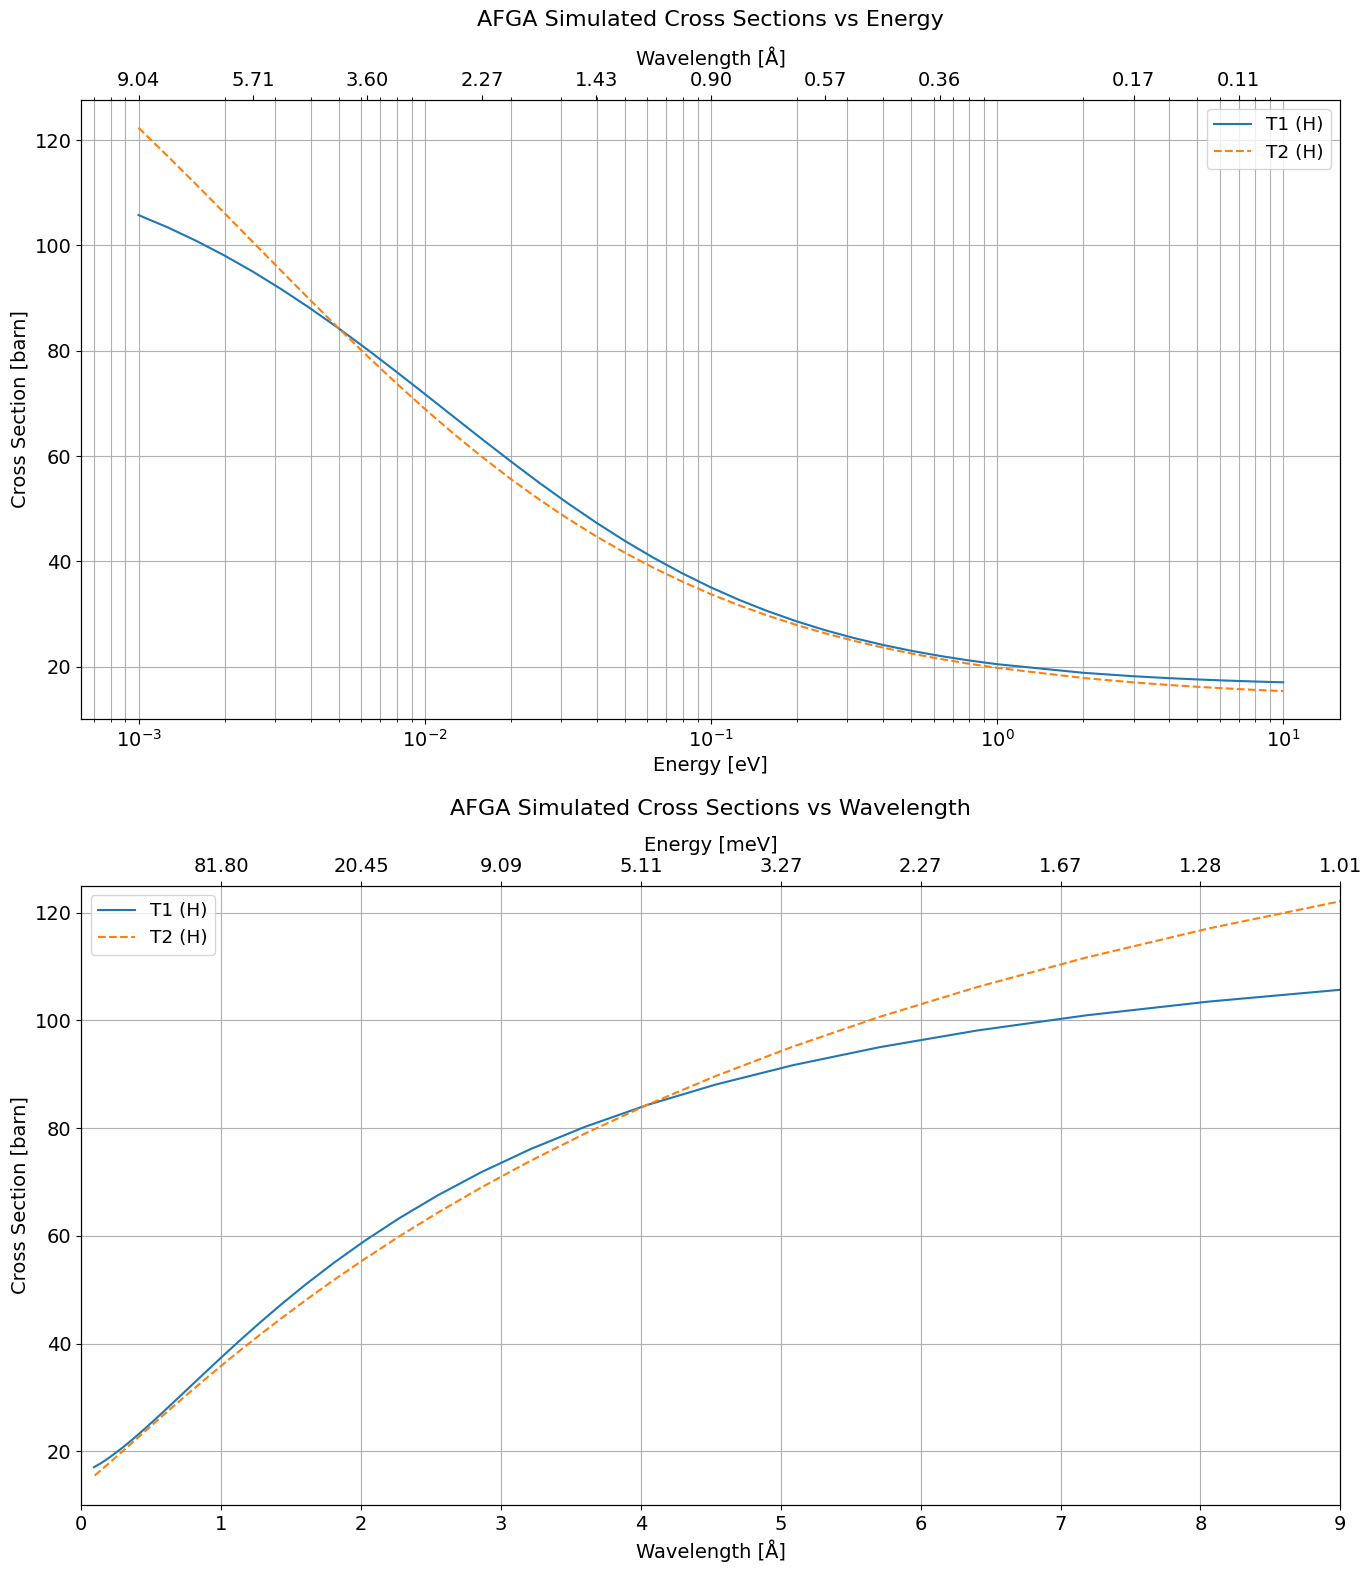

In [19]:
plot_all_CS(test, E_eV, calc_CS, plot_H=True, plot_T=False, wvl_limits=[(0, 9), (10, 125)])